In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

%matplotlib inline


In [2]:
#Extra functions helpers to make plots
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , size=4, aspect=2, **kwargs):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col, size = size, aspect = aspect  )
    facet.map( sns.barplot , cat , target, order=None )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 16 , 12 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ( round(model.score(X, y) * 100, 2))

## Read Data

In [3]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = 'redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5

connect_to_db = 'postgresql+psycopg2://' + \
                creds['username'] + ':' + creds['password'] + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




In [4]:
# build the pandas dataframe with the bid information
original_df = pd.read_sql_query("select * from ml_prep.last_bid_usd_with_offer", con)
original_df.head()

event_id            event_time  \
0  00483e6b-7847-4cc5-8206-c39f8bde6006  2017-09-25T07:22:08Z   
1  51e07bb7-911d-4a0f-84c0-a71cb2767156  2017-12-19T05:50:40Z   
2  028290a6-0ed8-477c-8ee6-9e4114f47572  2018-02-01T06:41:57Z   
3  cf8ac168-9c27-4519-99ad-5b05ee081b27  2018-02-11T10:51:40Z   
4  c7bae7ce-4690-46fd-8d4e-fe6a460f71b0  2017-11-29T07:46:34Z   

                           request_id  partner_id origin destination  \
0  Vn3uISbha8cjfSfXk2dxTPSXlqx9HiQxzf          35    MEL         SYD   
1  ZsqIRKIZwQWBbPPPyC9F8cdtzLEAdhqVo1          35    BNE         MEL   
2  58pz6ugBCW2Pwm4UTJjdsEpQqqin282mQA          35    MEL         PER   
3  quNUEqW1sZ99sWVA9gChwykTvlEAGIRNjI          35    PER         SYD   
4  Vtzp3JKan8NK9pn6RzaQcK07GP5hmE0EhX          35    BNE         MEL   

   flight_number departure_date departure_time currency     ...      \
0            819     2017-10-10          08:00      AUD     ...       
1            322     2018-02-16          09:55      AUD     ...       
2            697     2018-02-06          20:35      AUD     ...       
3            562     2018-02-15          15:30      AUD     ...       
4            334     2017-12-15          14:55      AUD     ...       

  slider_step duration  distance  distance_unit equipment slider_max_usd  \
0           5       85       439             mi       73H          349.0   
1           5      140       856             mi       73H          267.0   
2           5      260      1680             mi       73H          482.0   
3           5      250      2039             mi       332          547.0   
4           5      140       856             mi       73H          188.0   

  slider_min_usd slider_start_usd offer_amount customer_id  
0          111.0            127.0          NaN         NaN  
1          114.0            221.0          NaN         NaN  
2          218.0            318.0          NaN         NaN  
3          289.0            454.0          NaN         NaN  
4           90.0            148.0          NaN         NaN  

[5 rows x 33 columns]

In [5]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499597 entries, 0 to 499596
Data columns (total 33 columns):
event_id                              499597 non-null object
event_time                            499597 non-null object
request_id                            499597 non-null object
partner_id                            499597 non-null int64
origin                                499597 non-null object
destination                           499597 non-null object
flight_number                         499597 non-null int64
departure_date                        499597 non-null object
departure_time                        499597 non-null object
currency                              499597 non-null object
pnr                                   499597 non-null object
language                              499597 non-null object
pax                                   499597 non-null int64
eligibility                           499597 non-null bool
point_of_sale                         49

In [6]:
#drop non relevant fields
df = original_df.drop(['distance_unit', 'request_id', 'event_id', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', "instant_upgrade_eligibility"
        ], axis=1)

In [20]:
# add has_bid based on the offer_amount column

df['has_bid'] = df['offer_amount'].notnull()
df.tail()

event_time  partner_id origin destination  flight_number  \
499592  2017-09-23T16:49:47Z          35    PER         BNE            473   
499593  2017-11-26T12:29:14Z          35    BNE         DPS             43   
499594  2017-12-10T20:58:48Z          35    BNE         TSV            367   
499595  2017-12-09T09:28:26Z          35    BNE         SYD            966   
499596  2017-11-13T09:58:02Z          35    DPS         BNE             46   

       departure_date departure_time currency language  pax   ...    \
499592     2017-11-05          22:30      AUD       en    2   ...     
499593     2017-12-05          10:10      AUD       EN    1   ...     
499594     2017-12-19          08:50      AUD       EN    1   ...     
499595     2017-12-22          16:35      AUD       EN    1   ...     
499596     2017-11-26          21:10      AUD       en    2   ...     

             upgrade_type duration distance equipment slider_max_usd  \
499592  BUSINESS_DOMESTIC      280     2241       73H          477.0   
499593  BUSINESS_DOMESTIC      375     2791       73H          418.0   
499594  BUSINESS_DOMESTIC      120      693       73H          300.0   
499595  BUSINESS_DOMESTIC       95      465       73H          263.0   
499596  BUSINESS_DOMESTIC      355     2791       73H          418.0   

       slider_min_usd slider_start_usd  offer_amount  customer_id has_bid  
499592          235.0            394.0           NaN          NaN   False  
499593          220.0            365.0      304.4758    3894682.0    True  
499594           71.0            191.0           NaN          NaN   False  
499595          150.0            222.0           NaN          NaN   False  
499596          220.0            366.0           NaN          NaN   False  

[5 rows x 26 columns]

In [21]:
#What is the distribution of numerical feature values across the samples?
df.describe()

partner_id  flight_number            pax       duration       distance  \
count    499597.0  499597.000000  499597.000000  499597.000000  499597.000000   
mean         35.0     631.147805       1.630056     250.483318    1883.790962   
std           0.0     475.398008       0.894863     244.961144    2234.584466   
min          35.0       1.000000       1.000000      50.000000     147.000000   
25%          35.0     223.000000       1.000000      95.000000     465.000000   
50%          35.0     562.000000       1.000000     145.000000     867.000000   
75%          35.0     912.000000       2.000000     260.000000    2039.000000   
max          35.0    1898.000000       5.000000     950.000000    7936.000000   

       slider_max_usd  slider_min_usd  slider_start_usd  offer_amount  \
count   499597.000000   499597.000000     499597.000000  42242.000000   
mean       629.622488      260.109426        497.802084    196.012746   
std        938.403146      427.638611        793.238921    220.710500   
min        148.000000       40.000000         75.000000     45.523100   
25%        244.000000       93.000000        177.000000    100.850700   
50%        312.000000      116.000000        226.000000    131.747300   
75%        459.000000      231.000000        374.000000    224.110050   
max       5525.000000     3113.000000       4802.000000   4235.000000   

        customer_id  
count  4.224200e+04  
mean   3.625317e+06  
std    5.568267e+05  
min    1.851429e+06  
25%    3.649889e+06  
50%    3.819955e+06  
75%    3.967406e+06  
max    4.166364e+06

In [22]:
#What is the distribution of categorical feature values across the samples?
df.describe(include = ["O"])

event_time  origin destination departure_date  \
count                 499597  499597      499597         499597   
unique                269641      43          44            483   
top     2018-01-16T05:39:10Z     MEL         MEL     2017-12-22   
freq                      14  103340      103715           5280   

       departure_time currency language point_of_sale    channel_source  \
count          499597   499597   499597        499597            499597   
unique            227       14        3             3              6690   
top             11:15      AUD       en            GS  PRE_TRAVEL_EMAIL   
freq            11450   472012   282745        358360            158274   

       carrier_code fare_class from_cabin       upgrade_type equipment  
count        499597     499597     499597             499597    499597  
unique            1         16          2                  4         6  
top              VA          T    ECONOMY  BUSINESS_DOMESTIC       73H  
freq         499597     141892     494852             384236    372778

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499597 entries, 0 to 499596
Data columns (total 26 columns):
event_time          499597 non-null object
partner_id          499597 non-null int64
origin              499597 non-null object
destination         499597 non-null object
flight_number       499597 non-null int64
departure_date      499597 non-null object
departure_time      499597 non-null object
currency            499597 non-null object
language            499597 non-null object
pax                 499597 non-null int64
eligibility         499597 non-null bool
point_of_sale       499597 non-null object
channel_source      499597 non-null object
carrier_code        499597 non-null object
fare_class          499597 non-null object
from_cabin          499597 non-null object
upgrade_type        499597 non-null object
duration            499597 non-null int64
distance            499597 non-null int64
equipment           499597 non-null object
slider_max_usd      499597 non-null 

In [9]:
df179 = df[df["partner_id"] == 179].copy()
df179.drop(["partner_id", "eligibility"], axis = 1, inplace = True)
df179.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601776 entries, 0 to 874013
Data columns (total 23 columns):
event_time          601776 non-null object
origin              601776 non-null object
destination         601776 non-null object
flight_number       601776 non-null int64
departure_date      601776 non-null object
departure_time      601776 non-null object
currency            601776 non-null object
language            601776 non-null object
pax                 601776 non-null int64
point_of_sale       601776 non-null object
channel_source      601776 non-null object
carrier_code        601776 non-null object
fare_class          601776 non-null object
from_cabin          601776 non-null object
upgrade_type        601776 non-null object
duration            601776 non-null int64
distance            601776 non-null int64
equipment           601776 non-null object
slider_max_usd      601776 non-null float64
slider_min_usd      601776 non-null float64
slider_start_usd    601776 non-

In [15]:
#import missingno as msno
# Nullity or missing values by columns
#msno.bar(df)

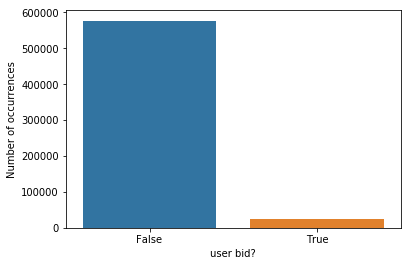

Has_bid percentage: 4.32%


In [16]:
#What is the distribution of has bid
sns.countplot(df179.has_bid);
plt.xlabel('user bid?');
plt.ylabel('Number of occurrences');
plt.show()
has_bid_counts = df179["has_bid"].value_counts().tolist()
print("Has_bid percentage: {0:.2f}%".format(has_bid_counts[1] / has_bid_counts[0] * 100))


## Conclusions about the original data

* missing data and unbalanced dataset


## Numerical analysis

## Visualization analysis

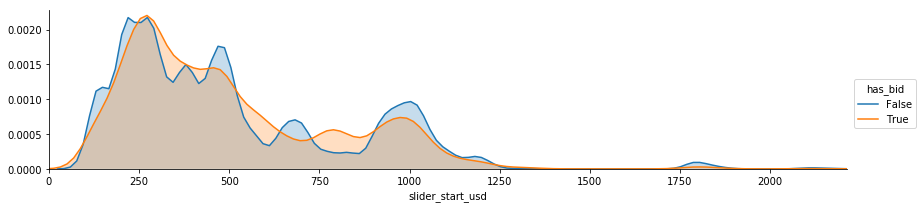

In [17]:
plot_distribution( df179 , var = 'slider_start_usd' , target = 'has_bid' )

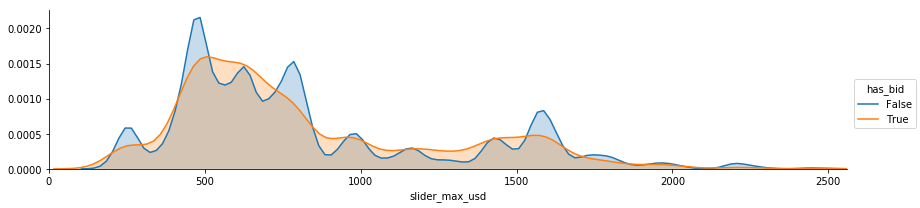

In [18]:
plot_distribution( df179 , var = 'slider_max_usd' , target = 'has_bid' )

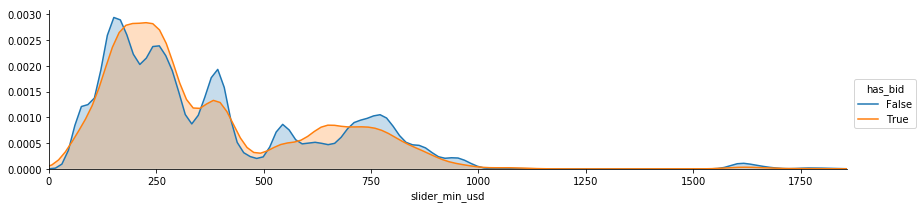

In [19]:
plot_distribution( df179 , var = 'slider_min_usd' , target = 'has_bid' )

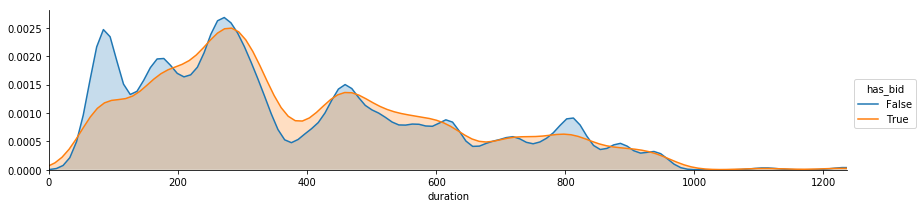

In [20]:
plot_distribution( df179 , var = 'duration' , target = 'has_bid' )

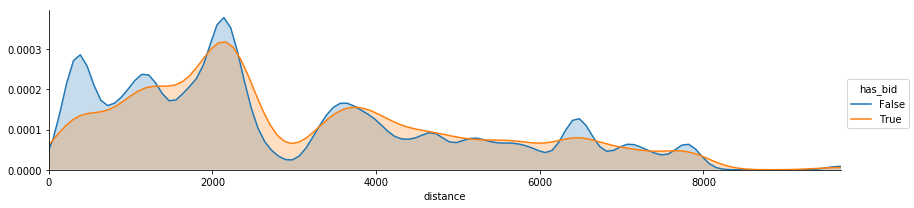

In [21]:
plot_distribution( df179 , var = 'distance' , target = 'has_bid' )

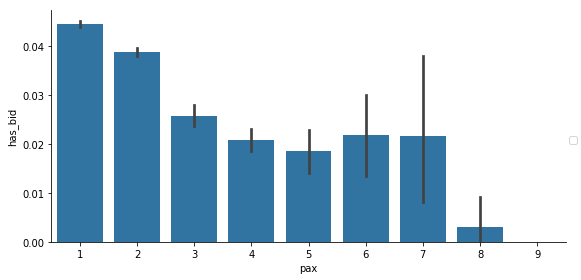

In [22]:
plot_categories( df179 , cat = 'pax' , target = 'has_bid' )

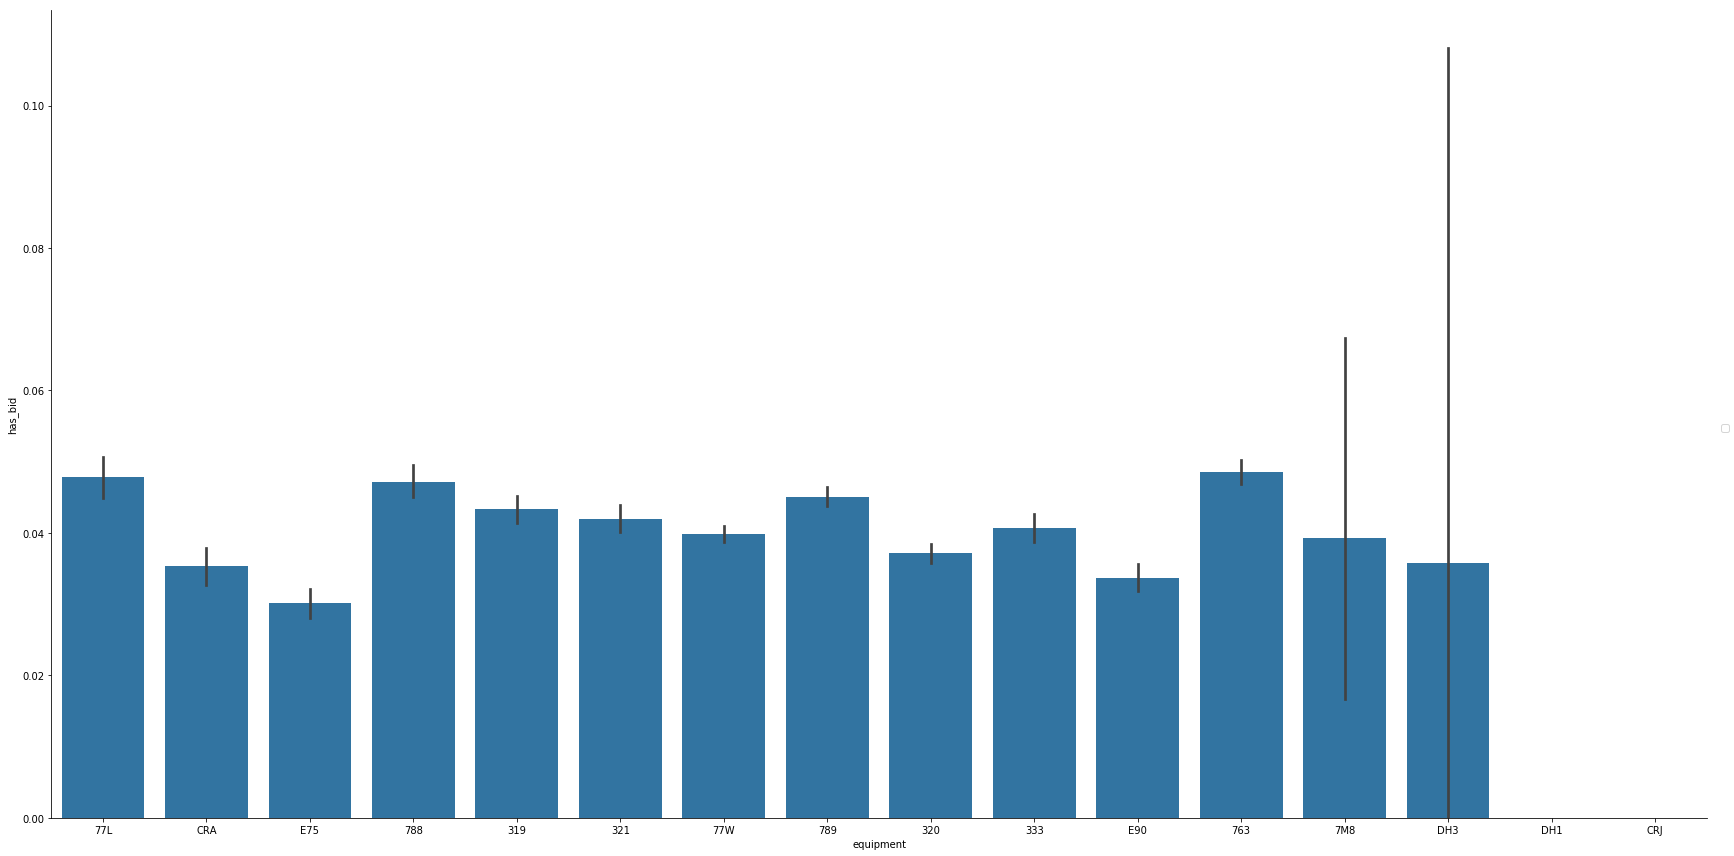

In [23]:
plot_categories( df179 , cat = 'equipment' , target = 'has_bid',size=12, aspect=2 )

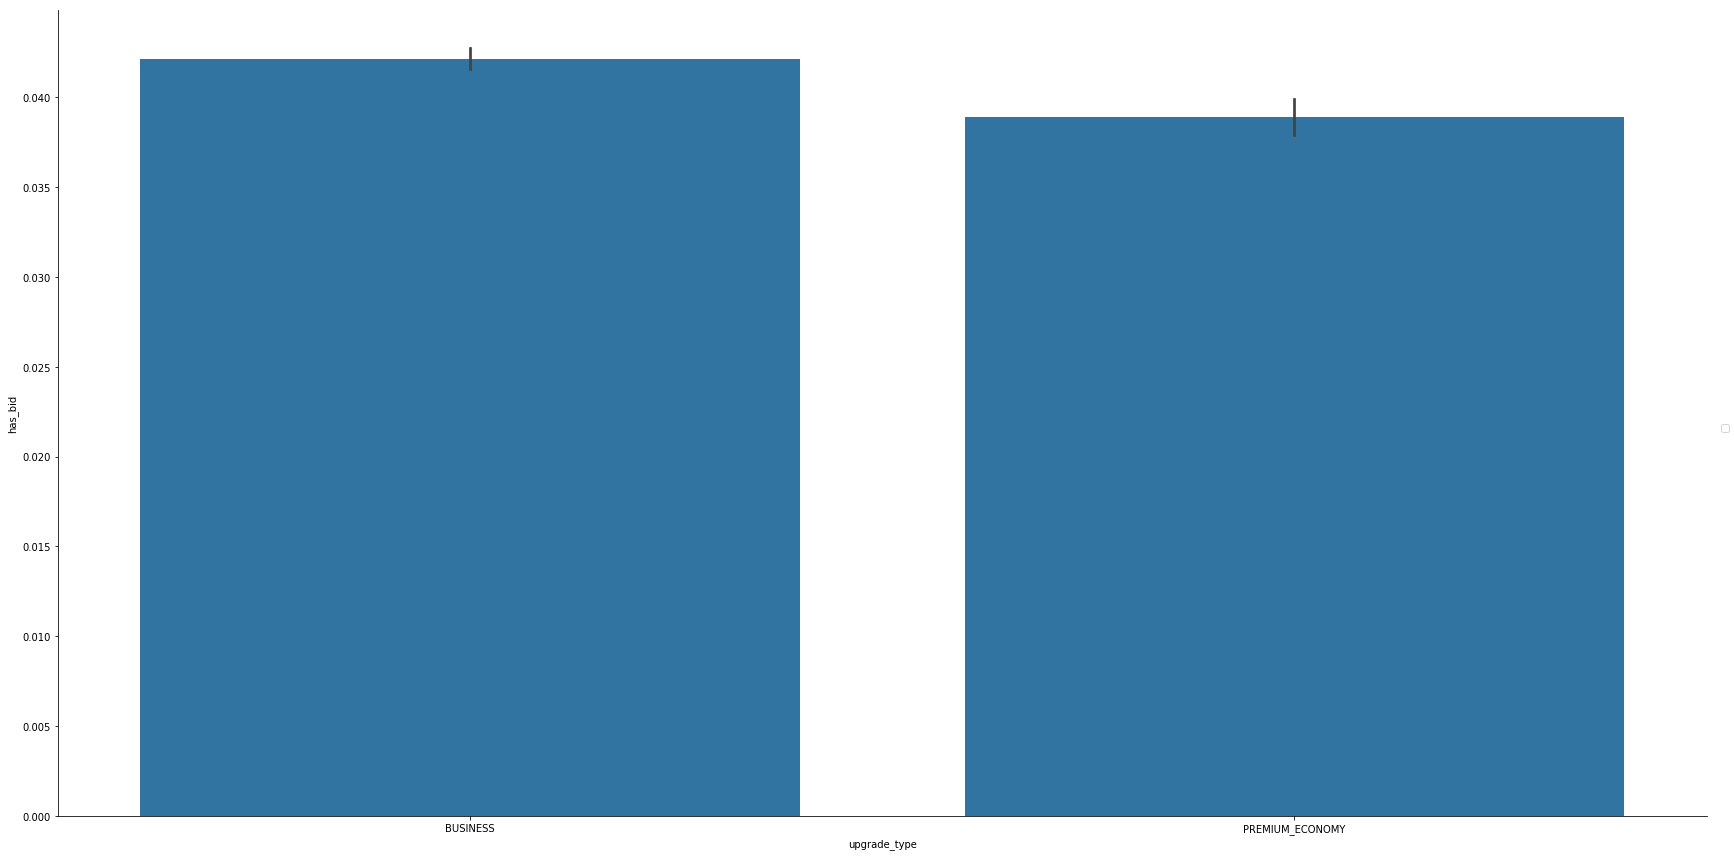

In [24]:
plot_categories( df179 , cat = 'upgrade_type' , target = 'has_bid',size=12, aspect=2 )

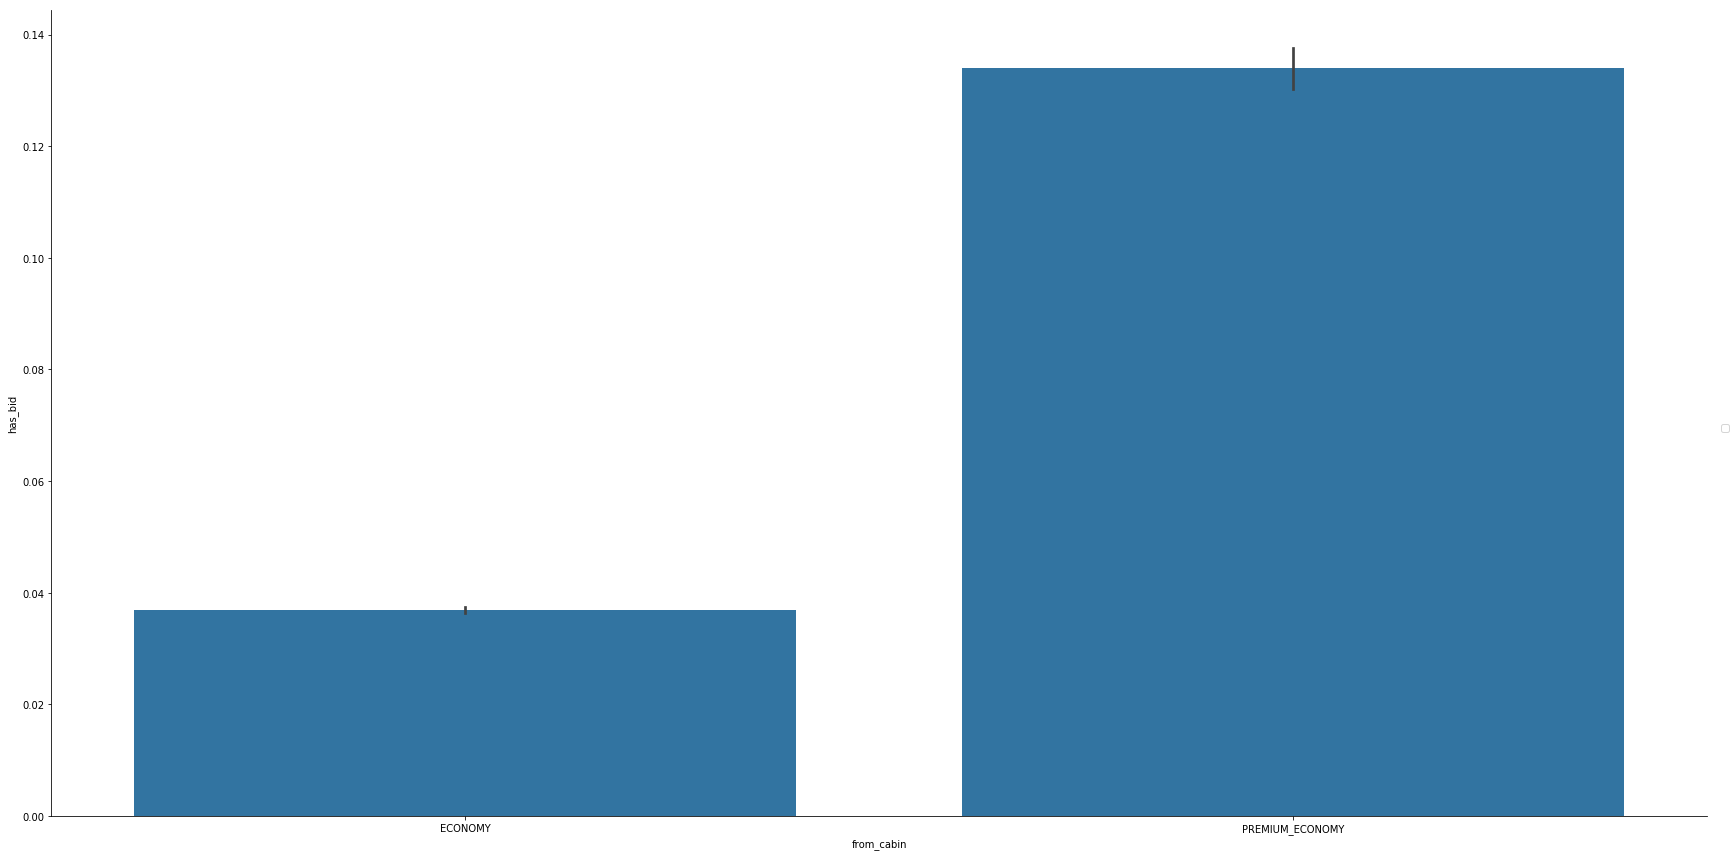

In [25]:
plot_categories( df179 , cat = 'from_cabin' , target = 'has_bid',size=12, aspect=2 )

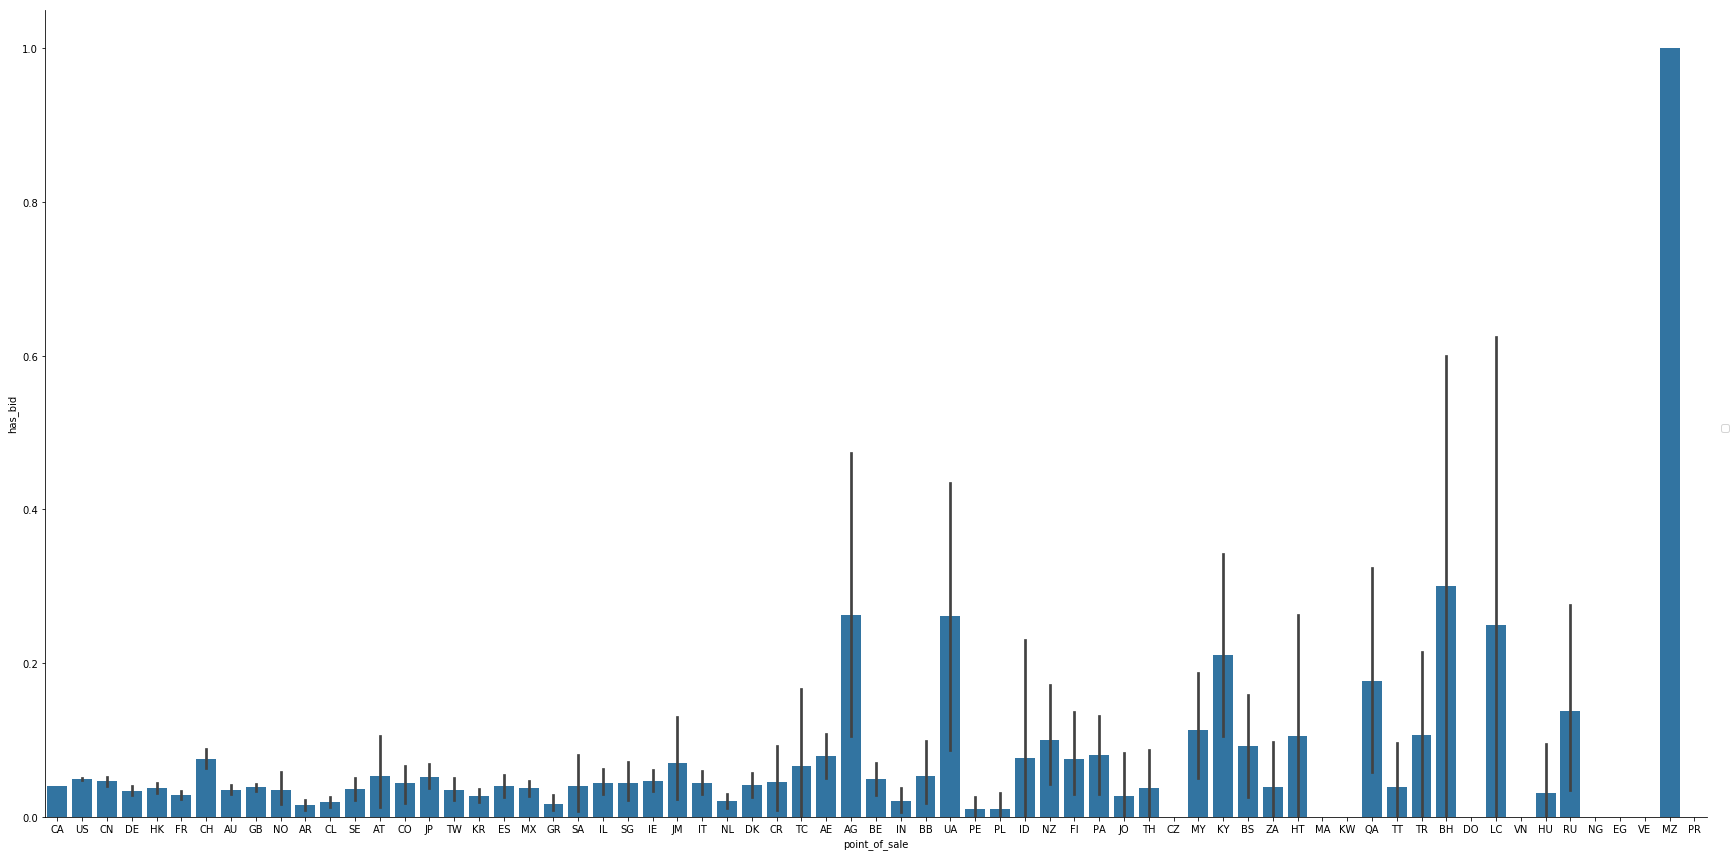

In [26]:
plot_categories( df179 , cat = 'point_of_sale' , target = 'has_bid',size=12, aspect=2 )

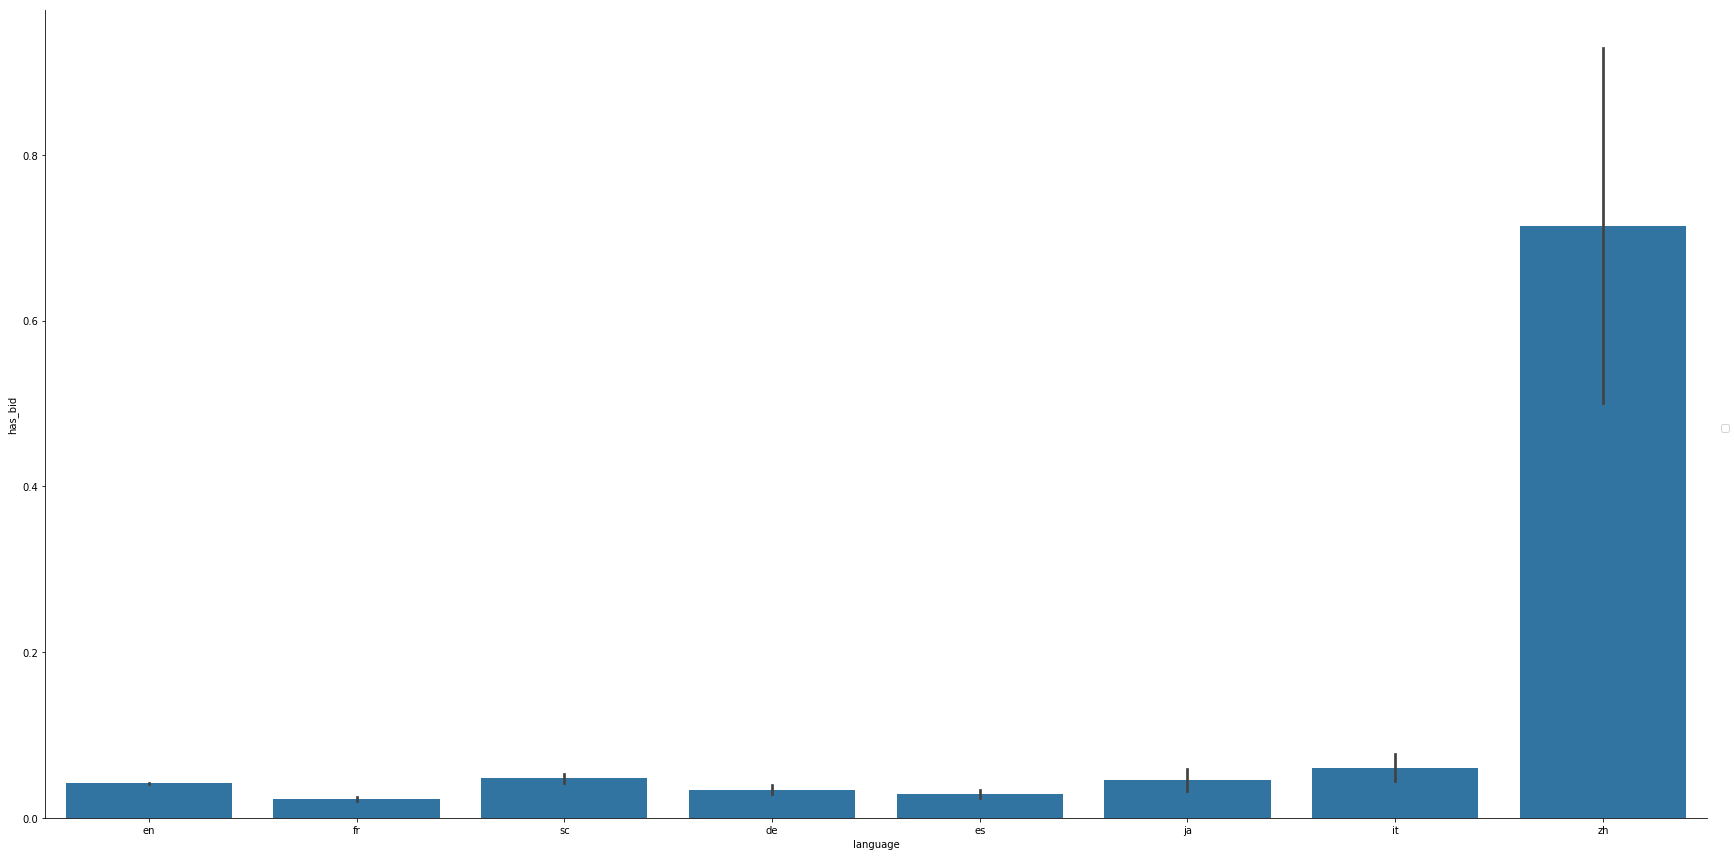

In [27]:
plot_categories( df179 , cat = 'language' , target = 'has_bid',size=12, aspect=2 )

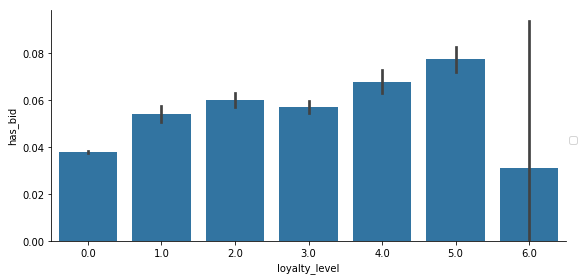

In [47]:
plot_categories( df179 , cat = 'loyalty_level' , target = 'has_bid' )

## Wrangle Data

### Removing features fill nans

In [37]:
df_nonNas = df179.copy()

#drop minutes from departure_time
df_nonNas["departure_time"] = df_nonNas.departure_time.apply(lambda x: str(x)[:-3] if len(str(x)) == 5  else x)

#fill equipment unknowns
df_nonNas['equipment'] = df_nonNas['equipment'].fillna("unknown")

#fill distance_amount and duration with means
#df_nonNas['distance_amount'] = df_nonNas['distance_amount'].fillna((df_nonNas['distance_amount'].mean()))
#df_nonNas['duration'] = df_nonNas['duration'].fillna((df_nonNas['duration'].mean()))
#don't show good results. maybe we can replace it with a better idea, like if the flag has_bid is true, we know that the flight
#probably will be long...
df_nonNas['distance'] = df_nonNas['distance'].fillna(0)
df_nonNas['duration'] = df_nonNas['duration'].fillna(0)
df_nonNas['loyalty_level'] = df_nonNas['loyalty_level'].fillna(-1)

df_nonNas['pax'] = df_nonNas['pax'].fillna(0)

#Convert float64 to float32
for column in ["pax", "slider_max_usd", "slider_min_usd", "slider_start_usd", "distance", "duration", "flight_number"]:
    df_nonNas[column] = df_nonNas[column].astype(np.float32)

train_df = df_nonNas.copy()


In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601776 entries, 1 to 874012
Data columns (total 23 columns):
event_time          601776 non-null object
origin              601776 non-null object
destination         601776 non-null object
flight_number       601776 non-null float32
departure_date      601776 non-null object
departure_time      601776 non-null object
currency            601776 non-null object
language            601776 non-null object
pax                 601776 non-null float32
point_of_sale       601776 non-null object
channel_source      601776 non-null object
carrier_code        601776 non-null object
fare_class          601776 non-null object
from_cabin          601776 non-null object
upgrade_type        601776 non-null object
duration            601776 non-null float32
distance            601776 non-null float32
equipment           601776 non-null object
slider_max_usd      601776 non-null float32
slider_min_usd      601776 non-null float32
slider_start_usd    601

### Prepare dataset

In [41]:
#we can factorize all values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def factorize_df(df, columns):
    train_df_fact = df.copy()
    train_df_fact["channel_source"] = df[["channel_source"]].apply(lambda x: pd.factorize(x)[0])
    for column in columns:
        le.fit(train_df_fact[column])
        train_df_fact[column] = le.transform(train_df_fact[column])
    return train_df_fact
 

In [42]:
columns_cat = ["origin", "destination", "equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]  
train_df_fact = factorize_df(train_df, columns_cat) 

In [43]:
train_df_fact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601776 entries, 1 to 874012
Data columns (total 23 columns):
event_time          601776 non-null object
origin              601776 non-null int64
destination         601776 non-null int64
flight_number       601776 non-null int64
departure_date      601776 non-null object
departure_time      601776 non-null int64
currency            601776 non-null int64
language            601776 non-null int64
pax                 601776 non-null float32
point_of_sale       601776 non-null int64
channel_source      601776 non-null int64
carrier_code        601776 non-null int64
fare_class          601776 non-null int64
from_cabin          601776 non-null int64
upgrade_type        601776 non-null int64
duration            601776 non-null float32
distance            601776 non-null float32
equipment           601776 non-null int64
slider_max_usd      601776 non-null float32
slider_min_usd      601776 non-null float32
slider_start_usd    601776 non-null f

## Create a model and evaluation

In [33]:
#Function utils
random_forest = RandomForestClassifier(n_estimators=100)

def do_undersampling(df_to_undersampling, target, desiredRate=0.10):
    # Get the indices per target value
    idx_0 = df_to_undersampling[df_to_undersampling[target] == False].index
    idx_1 = df_to_undersampling[df_to_undersampling[target] == True].index

    # Get original number of records per target value
    nb_0 = len(df_to_undersampling.loc[idx_0])
    nb_1 = len(df_to_undersampling.loc[idx_1])

    # Calculate the undersampling rate and resulting number of records with target=0
    undersampling_rate = ((1-desiredRate)*nb_1)/(nb_0*desiredRate)
    undersampled_nb_0 = int(undersampling_rate*nb_0)
    print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
    print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

    # Randomly select records with target=0 to get at the desired a priori
    undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

    # Construct list with remaining indices
    idx_list = list(undersampled_idx) + list(idx_1)

    # Return undersample data frame
    return df_to_undersampling.loc[idx_list].reset_index(drop=True)

def do_train(df_to_train, n_splits = 5):
    kf = KFold(n_splits, random_state = 1, shuffle = True)
    x = df_to_train.drop("has_bid", axis=1)
    y = df_to_train["has_bid"]
    
    for i, (train_index, test_index) in enumerate(kf.split(df_to_train)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = x.iloc[train_index,:].copy(), x.iloc[test_index,:].copy()
        print( "\nFold ", i+1)
        random_forest.fit(X_train, y_train)
        acc_random_forest = round(random_forest.score(X_valid, y_valid) * 100, 2)
        print("Accuracy = {}".format(acc_random_forest))
        Y_test_pred = random_forest.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = metrics.roc_curve(y_valid.astype(int), Y_test_pred)
        print("AUC = {}".format(metrics.auc(fpr, tpr)))

# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 

    return add_noise(ft_trn_series, noise_level)


### Feature engineering

* considering feature engineering from data exploration 2: origin-destination pair, days before departure.
* eval undersampling again, maybe removing features that don't have bid and 

#### Ideas explored:


* new fields from data exploration3 (upgrade_Type, from_cabin, language, point_of_sale) are valuable ?
* try make a pair with from_cabin and upgrade_type

In [44]:
#add days before departure and destination_origin
train_df2 = train_df.copy()
train_df2_020 = do_undersampling(train_df2, 'has_bid', 0.20)

train_df2_020["event_time"] = train_df2_020["event_time"].astype('datetime64[ns]')
train_df2_020["event_time"] = train_df2_020["event_time"].apply(lambda x: x.date() )
train_df2_020["departure_date"] = train_df2_020["departure_date"].astype('datetime64[ns]')
train_df2_020["departure_date"] = train_df2_020["departure_date"].apply(lambda x: x.date() )
train_df2_020["days_before_departure"] = train_df2_020["departure_date"] - train_df2_020["event_time"]
train_df2_020["days_before_departure"] = train_df2_020["days_before_departure"].apply(lambda x: x.days)
train_df2_020["destination_origin"] = train_df2_020["destination"]  + "-" + train_df2_020["origin"]

columns_cat2 = ["destination_origin", "origin", "destination", "equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]


train_df_fact2 = factorize_df(train_df2_020, columns_cat2) 


Rate to undersample records with target=0: 0.1726902548403369
Number of records with target=0 after undersampling: 99619


In [45]:
train_df_fact2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124524 entries, 0 to 124523
Data columns (total 25 columns):
event_time               124524 non-null object
origin                   124524 non-null int64
destination              124524 non-null int64
flight_number            124524 non-null int64
departure_date           124524 non-null object
departure_time           124524 non-null int64
currency                 124524 non-null int64
language                 124524 non-null int64
pax                      124524 non-null float32
point_of_sale            124524 non-null int64
channel_source           124524 non-null int64
carrier_code             124524 non-null int64
fare_class               124524 non-null int64
from_cabin               124524 non-null int64
upgrade_type             124524 non-null int64
duration                 124524 non-null float32
distance                 124524 non-null float32
equipment                124524 non-null int64
slider_max_usd           124524 non

In [46]:
do_train(train_df_fact2.drop(["departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale"], axis=1))


Fold  1
Accuracy = 79.54
AUC = 0.7007565274968589

Fold  2
Accuracy = 79.89
AUC = 0.704420156533068

Fold  3
Accuracy = 79.35
AUC = 0.7045798877715015

Fold  4
Accuracy = 79.65
AUC = 0.7054051126188233

Fold  5
Accuracy = 79.47
AUC = 0.7043875443708969


In [48]:
do_train(train_df_fact2.drop(["departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale", "loyalty_level"], axis=1))


Fold  1
Accuracy = 79.16
AUC = 0.6949070366197436

Fold  2
Accuracy = 79.48
AUC = 0.6934091036939388

Fold  3
Accuracy = 79.27
AUC = 0.699148002986077

Fold  4
Accuracy = 79.41
AUC = 0.700252247174555

Fold  5
Accuracy = 79.04
AUC = 0.6974248750321586


## Conslusions

*



In [ ]:
df_to_export = train_df2_020.drop(["departure_date","event_time", "language", "upgrade_type", "from_cabin", "point_of_sale"], axis=1)

df_to_export.to_csv("last_bid_data_exploration_3_no_fact_with_loyalty.csv", header=True, index=False)

In [ ]:
import boto3
boto3.Session().resource('s3').Bucket("pg-ml-repository").Object('sagemaker/data-exploration-artifacts/last_bid_data_exploration_3_no_fact_with_loyalty.csv').upload_file('last_bid_data_exploration_3_no_fact_with_loyalty.csv')


In [51]:
train_df2_no_undersampling = train_df.copy()

train_df2_no_undersampling["event_time"] = train_df2_no_undersampling["event_time"].astype('datetime64[ns]')
train_df2_no_undersampling["event_time"] = train_df2_no_undersampling["event_time"].apply(lambda x: x.date() )
train_df2_no_undersampling["departure_date"] = train_df2_no_undersampling["departure_date"].astype('datetime64[ns]')
train_df2_no_undersampling["departure_date"] = train_df2_no_undersampling["departure_date"].apply(lambda x: x.date() )
train_df2_no_undersampling["days_before_departure"] = train_df2_no_undersampling["departure_date"] - train_df2_no_undersampling["event_time"]
train_df2_no_undersampling["days_before_departure"] = train_df2_no_undersampling["days_before_departure"].apply(lambda x: x.days)
train_df2_no_undersampling["destination_origin"] = train_df2_no_undersampling["destination"]  + "-" + train_df2_no_undersampling["origin"]

columns_cat2 = ["destination_origin", "origin", "destination", "equipment", "currency", "language", "fare_class", "departure_time", "upgrade_type", "from_cabin", "point_of_sale", "carrier_code", "flight_number"]


train_df2_no_undersampling = factorize_df(train_df2_no_undersampling, columns_cat2) 

df_to_export = train_df2_no_undersampling.drop(["departure_date","event_time"], axis=1)

df_to_export.to_csv("last_bid_data_exploration_3_no_fact_with_loyalty_deep_learning.csv", header=True, index=False)
